In [1]:
from src import models, utils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
%load_ext autoreload
%autoreload 2

2025-02-06 18:29:38.828577: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 18:29:38.947096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738862978.999217  182557 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738862979.014589  182557 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 18:29:39.139692: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# 1. Setup and Data Preparation
- Define dataset paths, frame rate, and neural network configuration. 
- Load pedestrian data for specified situations.

In [3]:
dataset_path = "data/"
situations = ['Bottleneck_Data', 'Corridor_Data']
frame_rate = 1/16

data_loader = utils.data_loader.DataLoader(dataset_path, frame_rate)
data_loader.load_situations(situations)

# 2. Data Analysis
- Analyze a sample dataset and calculate mean spacings.
- Calculate mean spacings.

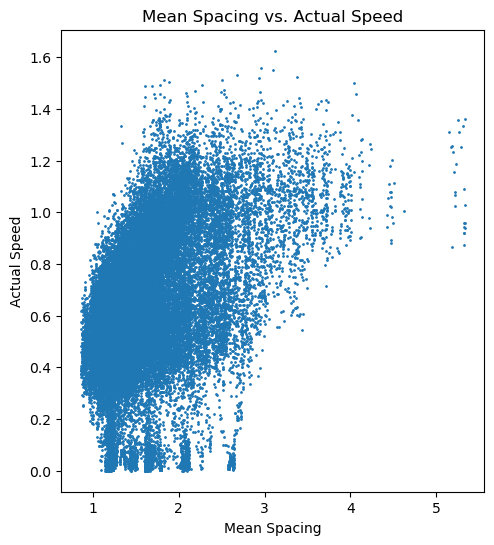

In [6]:
selected_situation = data_loader.get_situation_data('Corridor_Data', 'ug-180-085')

weidmann = models.modeling.WeidmannModel()

mean_spacings, updated_data, neighbors = weidmann.calculate_mean_spacing(selected_situation, k=10, three_d=False)
agent_speeds = weidmann.compute_agent_speeds(updated_data, frame_rate)
# print(mean_spacings)
# print(len(agent_speeds))
# print(type(agent_speeds))

# Get the first key and first key-value pair
first_key = next(iter(agent_speeds))  # Gets the first key
first_value = agent_speeds[first_key]  # Gets the value corresponding to the first key
# print(first_value)

utils.visualization.plot_mean_spacing_vs_speed(mean_spacings, agent_speeds)

- Predict speeds and calculate MSE using Weidmann model with example parameters.

In [7]:
v0, t, l_size = 0.957, 1.259, 0.957
print(agent_speeds[1])
mse, predicted_speeds = weidmann.calculate_weidmann_mse(mean_spacings, agent_speeds, v0, t, l_size)
print(f"Mean Squared Error (MSE) between actual and predicted speeds: {mse:.4f}")

{1: 0.06379520032102765, 2: 0.04099020448838822, 3: 0.07684372755144102, 4: 0.08993941569745666, 5: 0.05382306776838387, 6: 0.05487585756961013, 7: 0.045164698426979594, 8: 0.004924804158541991, 9: 0.04428878612019115, 10: 0.0, 11: 0.05385541294986109, 12: 0.027126941884406022, 13: 0.04537001935199126, 14: 0.04513628358648824, 15: 0.060209137379637755, 16: 0.02783200344926561, 17: 0.053300330055263, 18: 0.020478631204258076, 19: 0.036720125489981645, 20: 0.042922215040698874, 21: 0.030247740808200183, 22: 0.03302032925335451, 23: 0.08808606700267743, 24: 0.03210490404906968, 25: 0.09669047158846597, 26: 0.0626636992205217, 27: 0.06352366941542202, 28: 0.02640095028592821, 29: 0.05256606601220871, 30: 0.05148904411620206, 31: 0.025319872353548708, 32: 0.018702138487348946, 33: 0.016460330008840715, 34: 0.06032675612031903, 35: 0.12098588506102537, 36: 0.2269259440081709, 37: 0.20468723457998025, 38: 0.09140406082882752, 39: 0.013423885577581103, 40: 0.03991903485806989, 41: 0.0652644079

- Prepare data for neural network training.

In [8]:
# input_data = []
# output_data = []

# # Iterate over each agent and time_step in the nested dictionaries
# for agent in agent_speeds:
#     for time_step in agent_speeds[agent]:
#         if agent in mean_spacings and time_step in mean_spacings[agent] and agent in neighbors and time_step in neighbors[agent]:
#             neighbors_flattened = neighbors[agent][time_step].flatten()
#             mean_spacing = mean_spacings[agent][time_step]
#             speed = agent_speeds[agent][time_step]

#             input_data.append(np.append(neighbors_flattened, mean_spacing))
#             output_data.append(speed)

neural = models.modeling.NeuralNetworkModel()
input_data, output_data =  neural.prepare_training_data(agent_speeds, mean_spacings, neighbors)

# input_data = np.array(input_data)
# output_data = np.array(output_data)

- Normalize the data.
- Split the data into training and testing sets.

In [9]:
normalized_input_data = (input_data - np.mean(input_data, axis=0)) / np.std(input_data, axis=0)

X_train, X_test, y_train, y_test = train_test_split(normalized_input_data, output_data, test_size=0.5, random_state=42)

# 3. Neural Network Modeling and Training
- Create and train the neural network model.

In [10]:
input_dim = X_train.shape[1]
output_dim = 1
nn_hidden_layers = [3]

nn_model = neural.create_nn_model(input_dim, output_dim, nn_hidden_layers)

train_loss, val_loss, test_loss = neural.perform_bootstrapping(nn_model, X_train, y_train, X_test, y_test, bootstrap_samples=50, bootstrap_size=5000, k_folds=5, epochs=50, batch_size=32)

# history = nn_model.fit(X_train, y_train, epochs=50, validation_split=0.1)

Epoch 1/50


2025-02-06 18:32:32.338406: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0604 - val_loss: 0.5974
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5272 - val_loss: 0.2809
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2480 - val_loss: 0.1322
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1203 - val_loss: 0.0720
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0693 - val_loss: 0.0512
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0517 - val_loss: 0.0445
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0454 - val_loss: 0.0419
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0414 - val_loss: 0.0405
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0418 - val_loss: 0.0394
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0423 - val_loss: 0.0386
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0394 - val_loss: 0.0382
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

KeyboardInterrupt: 

- Visualize training and validation loss.

In [23]:
print(f"Bootstrapping Training Loss: {train_loss[0]}")
print(f"Bootstrapping Validation Loss: {val_loss[0]}")
print(f"Bootstrapping Test Loss: {test_loss[0]}")
# plt.figure(figsize=(12, 6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training and Validation Loss')
# plt.show()

Bootstrapping Training Loss: 0.027513928934931754
Bootstrapping Validation Loss: 0.02801840104162693
Bootstrapping Test Loss: 0.09251269010491682


- Evaluate the model on the test set.
- Predict using the trained model.

In [12]:
test_loss = nn_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")



828/828 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0269
Test Loss: 0.027006255462765694
828/828 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step
Predictions: [[0.5265669]
 [0.6166409]
 [0.6393404]
 [0.5541275]
 [0.5277652]]


# SFM Model (Social Force Model)

In [76]:
import numpy as np

def sfm_simulation(positions, velocities, goals, desired_speed, A, B, tau, time_steps):
    """
    Optimized Social Force Model simulation using NumPy vectorization.
    
    Args:
        positions (ndarray): Initial positions of pedestrians.
        velocities (ndarray): Initial velocities of pedestrians.
        goals (ndarray): Goal positions for each pedestrian.
        desired_speed (float): Desired walking speed for each pedestrian.
        A, B, tau: SFM parameters.
        time_steps (list): List of time steps for each pedestrian.
    
    Returns:
        speeds_per_participant (dict): Dictionary storing speeds at each time step for every pedestrian.
    """
    num_pedestrians = len(positions)
    speeds_per_participant = {}

    updated_positions = np.copy(positions)
    updated_velocities = np.copy(velocities)

    for i in range(num_pedestrians):
        time_step = 0
        pedestrian_positions = updated_positions[i]
        pedestrian_velocity = updated_velocities[i]
        pedestrian_goal = goals[i]

        for dt in time_steps[i]:  # Loop over this pedestrian's individual time steps
            time_step += dt

            # Compute direction to goal & desired velocity
            goal_direction = pedestrian_goal - pedestrian_positions
            goal_distance = np.linalg.norm(goal_direction) + 1e-6  # Avoid division by zero
            goal_direction /= goal_distance  # Normalize
            desired_velocity = desired_speed * goal_direction
            f_des = (desired_velocity - pedestrian_velocity) / tau

            # Compute pairwise repulsive forces (vectorized)
            displacements = updated_positions - pedestrian_positions  # Relative positions
            distances = np.linalg.norm(displacements, axis=1) + 1e-6  # Compute distances

            mask = np.arange(num_pedestrians) != i  # Exclude self
            direction_vectors = displacements / distances[:, None]  # Normalize directions
            repulsion_forces = A * np.exp((0.5 - distances) / B)[:, None] * direction_vectors
            f_rep = np.sum(repulsion_forces[mask], axis=0)

            # Update velocity and position
            total_force = f_des + f_rep
            pedestrian_velocity += total_force
            pedestrian_positions += pedestrian_velocity * dt

            # Store speeds efficiently
            if i not in speeds_per_participant:
                speeds_per_participant[i] = {}
            speeds_per_participant[i][time_step / frame_rate] = np.linalg.norm(pedestrian_velocity)

        # Update global positions and velocities
        updated_positions[i] = pedestrian_positions
        updated_velocities[i] = pedestrian_velocity

    return speeds_per_participant


In [19]:
import numpy as np

# Initialize dictionaries to store initial positions, velocities, and goals
initial_positions = {}
initial_velocities = {}
goals = {}

# Loop through each scenario in the bottleneck data
for ped_id in np.unique(updated_data[:, 0]):  # Unique pedestrian IDs
    ped_data = updated_data[updated_data[:, 0] == ped_id]  # Extract data for each pedestrian
    
    # Step 1: Extract initial position (at the first frame)
    first_frame = np.min(ped_data[:, 1])  # Find the first frame for each pedestrian
    initial_position = ped_data[ped_data[:, 1] == first_frame][:, 2:4]/100  # Extract X, Y, Z for the first frame
    if initial_position.size > 0:
        initial_positions[ped_id] = initial_position[0]
    # Step 2: Extract initial velocity 
    subsequent_frames = ped_data[ped_data[:, 1] > first_frame]/100  # Get frames after the first frame
    if len(subsequent_frames) > 0:
        second_frame = np.min(subsequent_frames[:, 1])  # Find the next frame after the first
        dx = subsequent_frames[subsequent_frames[:, 1] == second_frame, 2] - initial_position[0, 0]  # X displacement
        dy = subsequent_frames[subsequent_frames[:, 1] == second_frame, 3] - initial_position[0, 1]  # Y displacement
        

        
        # Calculate velocity (dx, dy / dt)
        velocity = np.array([dx, dy]) / 5
        initial_velocities[ped_id] = velocity.flatten()  # Flatten velocity for simplicity
    
    
    # Step 3: Goal (assuming last frame as the goal)
    goal_position = ped_data[ped_data[:, 1] == np.max(ped_data[:, 1]), 2:4]  # Get X, Y, Z at the last frame
    if goal_position.size > 0:
        goals[ped_id] = goal_position[0]/100
# Output the results
print("Initial Positions:", initial_positions)
print("Initial Velocities:", initial_velocities)
print("Goals:", goals)


Initial Positions: {np.float64(1.0): array([0.213381, 1.25304 ]), np.float64(2.0): array([0.503724, 2.58699 ]), np.float64(3.0): array([0.593512, 3.08695 ]), np.float64(4.0): array([0.907518, 1.35688 ]), np.float64(5.0): array([1.03428, 2.65075]), np.float64(6.0): array([1.23395, 3.40166]), np.float64(7.0): array([1.37134 , 0.877092]), np.float64(8.0): array([1.65164, 3.26531]), np.float64(9.0): array([0.219851, 3.51051 ]), np.float64(10.0): array([1.11818, 3.95966]), np.float64(11.0): array([0.118108, 4.3422  ]), np.float64(12.0): array([-0.103122,  5.13885 ]), np.float64(13.0): array([0.614624, 5.02579 ]), np.float64(14.0): array([0.489736, 5.6641  ]), np.float64(15.0): array([-0.478887,  5.05139 ]), np.float64(16.0): array([-0.503219,  6.15131 ]), np.float64(17.0): array([-0.452859,  5.97162 ]), np.float64(18.0): array([-0.490484,  5.37411 ]), np.float64(19.0): array([-0.469759,  5.89843 ]), np.float64(20.0): array([-0.468443,  4.74959 ]), np.float64(21.0): array([-0.4838 ,  5.88408

In [97]:
positions= np.array(list(initial_positions.values()))
velocities = np.array(list(initial_velocities.values()))
reach_goals = np.array(list(goals.values()))

A = 0.05  # Repulsion strength
B = 0.3 # Repulsion distance parameter
tau = 0.5  # Response time (time constant)
v0 = 1.58  # desired speed in m/s
# Dictionary to store time steps for each pedestrian
time_steps_dict = {}

participant_ids = np.unique(updated_data[:, 0])  # Extract unique participant IDs
for participant_id in participant_ids:
    # Extract data for the specific participant
    participant_data = updated_data[updated_data[:, 0] == participant_id]
    
    # Calculate time steps for this participant
    time_steps = np.diff(participant_data[:, 1]) * frame_rate
    
    # Store time steps in the dictionary
    time_steps_dict[participant_id] = time_steps.tolist()


data_time_steps = list(time_steps_dict.values())
# Convert time steps dictionary to a NumPy array (each pedestrian has a different time step)
dt = np.array([ts[0] if len(ts) > 0 else 1/16 for ts in data_time_steps])  

# Reshape `dt` to match velocity shape for element-wise division
dt = dt[:, None]  # Make it (N, 1) for N pedestrians

# Normalize velocities
velocities /= dt  # Scale velocity by its respective time step


predicted_speeds_sfm = sfm_simulation(positions, velocities, reach_goals, v0, A, B, tau, data_time_steps)

errors = []
for agent in mean_spacings:
    # Collect error for MSE calculation
    if agent in agent_speeds:
        actual_speeds = np.array(list(agent_speeds[agent].values())).flatten()  # Extract all actual speeds
        predicted_speeds = np.array(list(predicted_speeds_sfm[agent - 1].values())).flatten()  # Get predicted speeds
        error = (actual_speeds - predicted_speeds) ** 2
        errors.extend(error)

# Calculate Mean Squared Error
mse = np.mean(errors)
print(predicted_speeds_sfm[0])
print(agent_speeds[1])
print(mse)

{1.0: np.float64(0.18914932465588427), 2.0: np.float64(0.3625760646377377), 3.0: np.float64(0.5143789353110726), 4.0: np.float64(0.6472268995527612), 5.0: np.float64(0.7634956684906674), 6.0: np.float64(0.8652771908454708), 7.0: np.float64(0.9544112587960679), 8.0: np.float64(1.0325149202366604), 9.0: np.float64(1.10100817192785), 10.0: np.float64(1.1611365288232454), 11.0: np.float64(1.2139909465235632), 12.0: np.float64(1.2605248322253495), 13.0: np.float64(1.301566895251508), 14.0: np.float64(1.337827410436269), 15.0: np.float64(1.3698941200749628), 16.0: np.float64(1.398213513270504), 17.0: np.float64(1.4230586284265452), 18.0: np.float64(1.4445094293443927), 19.0: np.float64(1.46252484083948), 20.0: np.float64(1.477183973727373), 21.0: np.float64(1.4889393368135528), 22.0: np.float64(1.498541276101128), 23.0: np.float64(1.5067089367596807), 24.0: np.float64(1.5139266130163336), 25.0: np.float64(1.5204482993451922), 26.0: np.float64(1.5263828652880744), 27.0: np.float64(1.531772533

In [85]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function (MSE loss)
def objective_function(params, positions, velocities, reach_goals, data_time_steps, frame_rate, agent_speeds):
    A, B, tau = params  # Parameters to optimize

    # Run the SFM simulation with the current parameters
    predicted_speeds_sfm = sfm_simulation(positions, velocities, reach_goals, v0, A, B, tau, data_time_steps)

    errors = []
    for agent in agent_speeds:
        if agent in predicted_speeds_sfm:
            actual_speeds = np.array(list(agent_speeds[agent].values())).flatten()  # Extract actual speeds
            predicted_speeds = np.array(list(predicted_speeds_sfm[agent - 1].values())).flatten()  # Extract predicted speeds

            # Compute squared error
            error = (actual_speeds - predicted_speeds) ** 2
            errors.extend(error)

    mse = np.mean(errors)  # Compute mean squared error

    # Save the intermediate result
    iteration_log.append((params, mse))

    return mse

# Callback function to print intermediate results
iteration_log = []  # Stores (params, MSE) at each iteration

def callback(params):
    A, B, tau = params
    current_mse = iteration_log[-1][1]  # Get last stored MSE
    print(f"Iteration {len(iteration_log)}: A={A:.4f}, B={B:.4f}, tau={tau:.4f}, MSE={current_mse:.6f}")

# Initial guess for A, B, tau
initial_guess = [0.1, 0.5, 0.5]  # (A, B, tau)

# Expanded bounds to encourage parameter updates
bounds = [(0.01, 5), (00.1, 5), (00.1, 5)]  # Bounds for A, B, tau

# Callback function to track progress
def callback(params):
    A, B, tau = params
    mse = objective_function(params, positions, velocities, reach_goals, data_time_steps, frame_rate, agent_speeds)
    print(f"Iteration: A={A:.6f}, B={B:.6f}, tau={tau:.6f}, MSE={mse:.6f}")

# Optimize using Powell’s method
result = minimize(
    objective_function,
    initial_guess,
    args=(positions, velocities, reach_goals, data_time_steps, frame_rate, agent_speeds),
    method='Powell',  
    bounds=bounds,
    options={'maxiter': 500, 'disp': True},  # Display optimization progress
    callback=callback
)

# Print final results
optimal_A, optimal_B, optimal_tau = result.x
final_mse = result.fun
print(f"\nOptimal A: {optimal_A:.6f}, Optimal B: {optimal_B:.6f}, Optimal tau: {optimal_tau:.6f}")
print(f"Final MSE: {final_mse:.6f}")
# Get optimal parameters
optimal_A, optimal_B, optimal_tau = result.x
print(f"\nOptimal A: {optimal_A}, Optimal B: {optimal_B}, Optimal tau: {optimal_tau}")
print(f"Final MSE: {result.fun}")


Iteration: A=0.061441, B=0.541833, tau=0.541833, MSE=0.264284
Iteration: A=0.055761, B=1.931793, tau=0.866357, MSE=0.294865
Optimization terminated successfully.
         Current function value: 0.294865
         Iterations: 2
         Function evaluations: 126

Optimal A: 0.055761, Optimal B: 1.931793, Optimal tau: 0.866357
Final MSE: 0.294865

Optimal A: 0.05576143804376774, Optimal B: 1.9317934232221767, Optimal tau: 0.8663565444609107
Final MSE: 0.2948647622310847
